In [2]:
# 导入所用的库
import sys
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [7]:
# 读取数据
train = pd.read_csv('train.csv', parse_dates=['Date'])
test = pd.read_csv('test.csv')

# 填充空值
train.replace(['NR'], [0.0], inplace = True)
test.replace(['NR'], [0.0], inplace = True)

0         AMB_TEMP
1              CH4
2               CO
3             NMHC
4               NO
5              NO2
6              NOx
7               O3
8             PM10
9            PM2.5
10        RAINFALL
11              RH
12             SO2
13             THC
14           WD_HR
15      WIND_DIREC
16      WIND_SPEED
17           WS_HR
18        AMB_TEMP
19             CH4
20              CO
21            NMHC
22              NO
23             NO2
24             NOx
25              O3
26            PM10
27           PM2.5
28        RAINFALL
29              RH
           ...    
4290           NOx
4291            O3
4292          PM10
4293         PM2.5
4294      RAINFALL
4295            RH
4296           SO2
4297           THC
4298         WD_HR
4299    WIND_DIREC
4300    WIND_SPEED
4301         WS_HR
4302      AMB_TEMP
4303           CH4
4304            CO
4305          NMHC
4306            NO
4307           NO2
4308           NOx
4309            O3
4310          PM10
4311        

In [41]:
# 数据值处理:归一化
def myStandardize(file):
    cols = list(file.columns)   # 提取原文件中列名
    vals = []                   # 准备空列表，填充归一化后的数据
    for i in cols[2:]:          # 从原文件第2列后开始处理
        x = file.loc[:, i]      # 选中第i列
        new_x = list(preprocessing.scale(x))  # 逐列归一化（Standardize）
        vals.append(new_x)      # 将归一化的列填充到vals列表中
    vals = np.array(vals).transpose()   # 将归一化的列表转换成array并转置
    vals = pd.DataFrame(vals)           # 将上一步得到的array变成dataframe
    cols_id = file.iloc[:,:2]           # 提取原文件中前2列编号名称
    new_file = pd.merge(cols_id,vals,left_index = True,right_index=True) # 将归一化数据与编号合并成新表
    return new_file             # 查看归一化后的新数据表

new_train = myStandardize(train)
new_test = myStandardize(test)

In [52]:
# 提取feature（train中归一化后的X值）、label（未处理的PM2.5值）、用于预测的feature（test中归一化后的X值）
def extractFeaLab(file_1,file_2,file_3):
    my_indexs1 = file_1.iloc[:,0].drop_duplicates()
    my_indexs2 = file_3.iloc[:,0].drop_duplicates()
    train_X = []
    train_Y = []
    test_X = []
    for id in my_indexs1:
        fea_array1 = np.array(file_1[file_1.iloc[:,0] == id].iloc[:, 2:], dtype = np.float32)
        lab_array1 = np.array(file_2[file_2.iloc[:,0] == id].iloc[:, 2:], dtype = np.float32)
        for hour in range(24 - 8):
            fea = fea_array1[:, hour:hour + 8].flatten()    # 将array平坦化（降维）
            label = lab_array1[9, hour + 8].flatten()    # 将array平坦化（降维）
            train_X.append(fea)
            train_Y.append(label)
    
    for id in my_indexs2:
        fea_array2 = np.array(file_3[file_3.iloc[:,0] == id].iloc[:, 2:], dtype = np.float32)
        fea2 = fea_array2.flatten()    # 将array平坦化（降维）
        test_X.append(fea2)
   
    train_X_ = np.array(train_X)
    train_Y_ = np.array(train_Y)
    test_X_ = np.array(test_X)
    print(train_X_.shape)  # (16*240=3840,18*8=144)：由new_train得到3840个144维特征
    print(train_Y_.shape)  # (3840,1)：由train得到3840个PM2.5原预测值
    print(test_X_.shape)   # (240,18*8=144)：有240个待输入的特征，来预测test中的PM2.5值
    return train_X_, train_Y_ , test_X_

train_X_, train_Y_, test_X_ = extractFeaLab(new_train,train,new_test)

(3840, 144)
(3840, 1)
(240, 144)


训练集测试及参数:
 X_train.shape=(3600, 144)
 y_train.shape =(3600, 1)
 X_test.shape=(240, 144)
 y_test.shape=(240, 1)
模型参数:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
模型截距:
 [134.25134]
参数权重:
 [[-8.15998840e+00  2.59319997e+00 -1.57167225e+01  4.28859901e+00
   9.77858353e+00  9.36229324e+00 -8.41444874e+00  5.66428900e+00
   7.32145081e+01  8.53218689e+01  7.00351410e+01 -6.26520195e+01
   6.31422615e+01 -9.72943726e+01 -1.07101814e+02  4.08701859e+01
  -2.29620094e+01  5.52968025e+00 -1.61053219e+01  4.65510178e+01
   2.35472469e+01 -2.17856178e+01  8.74934006e+00  1.30754471e+02
   3.19707565e+01 -1.37068451e+02  1.48377197e+02 -1.48164825e+02
  -1.76690414e+02  1.09602089e+02  6.72065048e+01  1.09040436e+02
   2.24671936e+01  1.03241596e+01 -3.19260635e+01  4.13509083e+00
  -2.12898397e+00  9.49848938e+00 -4.25645828e-01 -1.90235043e+00
   5.32054424e+00  4.85417080e+00 -3.30084953e+01  2.49328613e+00
  -1.82527304e+00 -2.65002012e+00 -7.54728317e+00 

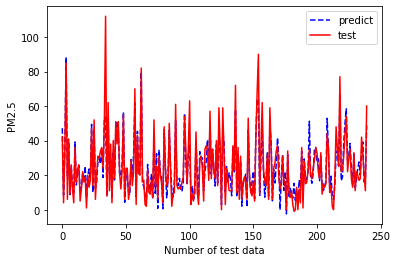

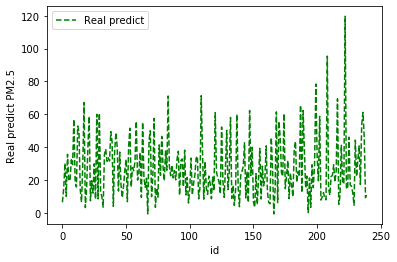

In [53]:
# 在训练集上训练模型，并划分16:1验证集进行验证，计算RMSE
def myLinearReg():
    X_train, X_test, y_train, y_test = train_test_split(train_X_, train_Y_, test_size = 240/3840, random_state = 123)
    
    print('训练集测试及参数:')
    print(' X_train.shape={}\n y_train.shape ={}\n X_test.shape={}\n y_test.shape={}'
          .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    linreg = LinearRegression()
    model = linreg.fit(X_train, y_train)
    print('模型参数:\n', model)
    print('模型截距:\n',linreg.intercept_)
    print('参数权重:\n',linreg.coef_)
    
    y_pred = linreg.predict(X_test)
    sum_mean = 0
    for i in range(len(y_pred)):
        sum_mean += (y_pred[i] - y_test[i]) ** 2
    sum_erro = np.sqrt(sum_mean /len(y_pred))  # 测试集的数量
    print ("RMSE(在验证集中):", sum_erro)
    
    # 画出验证集预测情况
    plt.figure()
    plt.plot(range(len(y_pred)), y_pred, 'b', linestyle = '--', label = "predict")
    plt.plot(range(len(y_pred)), y_test, 'r', linestyle = 'solid', label = "test")
    plt.legend(loc = "best")  # 显示图中的标签
    plt.xlabel("Number of test data")
    plt.ylabel('PM2.5')
    plt.show()
    
    # 将训练好的模型用在test数据上进行预测
    y_pred2 = linreg.predict(test_X_)
    
    # 画出预测情况
    plt.figure()
    plt.plot(range(len(y_pred2)), y_pred2, 'g', linestyle = '--', label = "Real predict")
    plt.legend(loc = "best")  
    plt.xlabel("id")
    plt.ylabel('Real predict PM2.5')
    plt.show()
    
    # 将结果存储数据到sampleSubmission.csv
    result = pd.DataFrame(y_pred2)
    result.columns = ['values']
    id_names = []
    for i in range(len(result)):
        id_names.append('id_%d' % i)
    result.index = id_names
    result.index.name = 'id'
    result.to_csv('sampleSubmission.csv')
myLinearReg()